In [1]:
import ftplib
import os
import pandas as pd
import youtokentome as yttm
from functools import partial
import gzip
from BCBio import GFF
import numpy as np
import smart_open
import gensim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import cm
import jupyter_beeper
beep = jupyter_beeper.Beeper()

model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_8192k.model"
# model_path = "/gpfs/data/johnsonslab/nlp-genomics/pasolli-2019/metagenomes_1000bp_8192.model"
bpe = yttm.BPE(model=model_path)


In [2]:
def retrieve_genomes(path, gzipped=False):
    if(gzipped):
        with gzip.open(path, 'r') as f:
            file_content = f.readlines()
            file_content = [content.strip() for content in file_content]
            
    else:
        with open(path, 'r') as f:
            file_content = f.readlines()
            file_content = [content.strip() for content in file_content]
    if isinstance(file_content[0], bytes):
        file_content = [line.decode('utf') for line in file_content]
    genomes = {}
    bases = ""
    header = file_content[0]
    
    for i in range(1, len(file_content)):
        if(">") in file_content[i]:
            genomes[header] = bases
            header = file_content[i]
            bases=""
        else:
            bases+= file_content[i] 
            if(i==len(file_content)-1):
                genomes[header] = bases
                header = file_content[i]
                bases=""
    return genomes

def retrieve_genome_from_gff(in_file):
    with(open(in_file)) as in_handle:
        return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])
    
def retrieve_genome_from_genome_name(name):
    with(open(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/',name + '.gff'))) as in_handle:
        return "".join([str(rec.seq) for rec in GFF.parse(in_handle)])

def write_seq_from_gff(name, path):
    genome = retrieve_genome_from_genome_name(name)
    with (open(os.path.join(path, name +'.txt'), 'w' )) as f:
        f.write(genome)
def read_seq_from_txt(name, path):
    with open(os.path.join(path, name + '.txt'), 'r') as f:
        for line in f:
            return line
    
def tokenize_with_length_threshold(string, length_threshold=100):
    tokens= bpe.encode(string, output_type =yttm.OutputType.SUBWORD )
    out = []
    for token in tokens:
        if(len(token)>=length_threshold):
            out.append(token)
    if(len(out)==0):
        out.append("none")
#     print(len(tokens), len(out))
    return out


def get_clades(filename, df):
    idx = filename[:-4]
    lineage = df.loc[idx].Lineage
    domain = lineage[lineage.find('d__')+3:lineage.find(';')]
    phylum_start_idx = lineage.find('p__')+3
    phylum_end_idx = lineage[phylum_start_idx:].find(';')+phylum_start_idx
    phylum = lineage[phylum_start_idx:phylum_end_idx]
    class_start_idx = lineage.find('c__')+3
    class_end_idx = lineage[class_start_idx:].find(';')+class_start_idx
    class_ = lineage[class_start_idx:class_end_idx] #named so as not to break python
    order_start_idx = lineage.find('o__')+3
    order_end_idx = lineage[order_start_idx:].find(';')+order_start_idx
    order = lineage[order_start_idx:order_end_idx]
    family_start_idx = lineage.find('f__')+3
    family_end_idx = lineage[family_start_idx:].find(';')+family_start_idx
    family = lineage[family_start_idx:family_end_idx]
    genus_start_idx = lineage.find('g__')+3
    genus_end_idx = lineage[genus_start_idx:].find(';')+genus_start_idx
    genus = lineage[genus_start_idx:genus_end_idx]
    species = get_name_from_file(filename, df)
    return domain, phylum, class_, order, family, genus, species


    return domain, phylum
def get_name_from_file(filename, df):
    idx = filename[:-4]
    lineage = df.loc[idx].Lineage
    if(lineage.rfind(" ")==-1):
        genus_start_idx = lineage.find('g__')+3
        genus_end_idx = lineage[genus_start_idx:].find(';')+genus_start_idx
        genus = lineage[genus_start_idx:genus_end_idx]

        return genus + " " + '[none]'
    name = lineage[lineage.find('s__')+3:lineage.find('s__')+4] + "." + lineage[lineage.rfind(" "):]
    return name
def get_species_status(filename, df):
    if(filename[:-4] not in df.index):
        return False
    name = get_name_from_file(filename, df)
    if(name=="._"):
        return False
    else:
        return True
    


### Load metadata

In [3]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'

# %cd /gpfs/data/johnsonslab/nlp-genomics/almeida-2020
os.chdir(path)
# print(os.getcwd())
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
df

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
Genome,,,,,,,,,,,,,,,,,,,
MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.70,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000002,Isolate,4433109,101,109267,42.60,99.37,0.00,82.35,95.37,86.19,19,GUT_GENOME000004,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS370064,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000003,Isolate,3229518,35,158570,58.52,100.00,0.00,94.96,99.67,99.66,20,GUT_GENOME000008,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,ERS370070,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000004,Isolate,3698896,105,90297,54.19,98.66,0.22,93.28,99.67,99.83,20,GUT_GENOME000010,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS370072,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000005,Isolate,3930428,32,350032,28.59,99.30,0.00,89.08,99.67,99.83,20,GUT_GENOME000017,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS417217,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000289389,MAG,2401111,16,227958,45.09,97.58,0.24,0.00,0.00,5.47,14,GUT_GENOME155261,MGYG000000280,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS475251,ERP005860,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000289390,MAG,1083388,311,3789,45.91,67.48,1.50,0.00,0.00,0.00,17,GUT_GENOME110173,MGYG000004337,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o...,ERS328872,ERP003612,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000289391,MAG,2202510,153,20278,44.45,94.07,0.84,93.28,0.00,0.00,16,GUT_GENOME024976,MGYG000000669,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS1444564,ERP019502,Kazakhstan,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


In [7]:
##Old code for testing whether or not a file is missing from the dataset
# %%time
# gffs_path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/'
# gffs_list = os.listdir(gffs_path)
# missing = []
# for i, genome in enumerate(df.index):
#     if(genome + '.gff' not in gffs_list):
#         print(i, genome)
#         missing.append(genome)
# print(len(missing))

In [5]:
%%time
#Get count of all families 
domains = []
all_domains = []
phyla = []
all_phyla = []
classes = []
all_classes = []
orders = []
all_orders = []
families = []
all_families = []
species_names = []
filenames = []
genera = []
all_genera = []
for name in df.index:
    filename = name + '.gff'
    domain, phylum, class_, order, family, genus, species = get_clades(filename, df)
    species_name = get_name_from_file(filename, df)
    if(species_name not in species_names):
        domains.append(domain)
        phyla.append(phylum)
        classes.append(class_)
        orders.append(order)
        families.append(family)
        filenames.append(filename)
        genera.append(genus)
        species_names.append(species_name)
    all_domains.append(domain)
    all_phyla.append(phylum)
    all_classes.append(class_)
    all_orders.append(order)
    all_families.append(family)
    all_genera.append(genus)
unique_families = set(families)
unique_genera = set(genera)
print(len(unique_families), "unique families,", len(unique_genera), "unique genera")
families_df = pd.Series(families)
print("Non-redundant families: ", len(families), ", all families: ", len(all_families))
family_counts = families_df.value_counts()
family_counts[:10]

202 unique families, 1008 unique genera
Non-redundant families:  3791 , all families:  289232
CPU times: user 2min 3s, sys: 160 ms, total: 2min 3s
Wall time: 2min 3s


Lachnospiraceae       436
Coriobacteriaceae     281
Bacteroidaceae        226
Oscillospiraceae      192
Acutalibacteraceae    181
Ruminococcaceae       140
UBA660                122
Enterobacteriaceae    112
Muribaculaceae         95
CAG-508                83
dtype: int64

In [6]:
##Threshold to non-redundant families with over 
family_counts_over_100 = family_counts[family_counts>100]
print((family_counts_over_100))
len(family_counts_over_100)

Lachnospiraceae       436
Coriobacteriaceae     281
Bacteroidaceae        226
Oscillospiraceae      192
Acutalibacteraceae    181
Ruminococcaceae       140
UBA660                122
Enterobacteriaceae    112
dtype: int64


8

In [7]:
unique_species = pd.DataFrame({"file":filenames, "domain": domains, 
                               "phylum":phyla,"class":classes, 
                               "order":orders, "family":families, 
                               "genus":genera, "species name":species_names})
unique_species.to_csv("unique_species.csv", index=False)


In [5]:
unique_species = pd.read_csv("unique_species.csv", index_col=0)
unique_species

,domain,phylum,class,order,family,genus,species name
file,,,,,,,
MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...
MGYG000004884.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,KLE1615,KLE1615 [none]
MGYG000004886.gff,Bacteria,Actinobacteriota,Actinomycetia,Actinomycetales,Micrococcaceae,Rothia,Rothia [none]
MGYG000004887.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA1417,U. sp002305575


In [16]:
np.random.seed(42)
test_genome = retrieve_genome_from_genome_name(unique_species.index[np.random.choice(len(unique_species))][:-4])
print("Pre-tokenization length:",len(test_genome))
tokenized_test_genome = bpe.encode(test_genome, output_type =yttm.OutputType.SUBWORD)
print("Tokenized length:", len(tokenized_test_genome))
chunks = []
for i in range(0, len(test_genome), 1000):
    stretch = test_genome[i:i+1000]
    if(len(stretch)<1000):
        stretch = stretch + "0" * (1000 - len(stretch))
    chunk = bpe.encode(stretch, output_type =yttm.OutputType.SUBWORD)
    chunks.append(chunk)
total = 0
maxlen = -np.inf
minlen = np.inf
for i in range(len(chunks) - 1):
    total +=len(chunks[i])
    maxlen = max(maxlen, len(chunks[i]))
    minlen = min(minlen, len(chunks[i]))
print("Average number of tokens:", total/(len(chunks)-1))
print("Maximum number of tokens:", maxlen)
print("Minimum number of tokens:", minlen)

Pre-tokenization length: 2521949
Tokenized length: 463062
Average number of tokens: 184.79174930583102
Maximum number of tokens: 197
Minimum number of tokens: 165


# Attempting NCD (gzip+kNN) method

### Getting high count family DF

In [23]:
import pandas as pd
unique_species = pd.read_csv("/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/unique_species.csv", index_col=0)
family_counts = unique_species['family'].value_counts()

In [24]:
n=50
family_counts_over_n= family_counts[family_counts>n]
print((family_counts_over_n))
print(len(family_counts_over_n))
all_families_over_n= unique_species[unique_species['family'].isin(family_counts_over_n.index)]


family
Lachnospiraceae         436
Coriobacteriaceae       281
Bacteroidaceae          226
Oscillospiraceae        192
Acutalibacteraceae      181
Ruminococcaceae         140
UBA660                  122
Enterobacteriaceae      112
Muribaculaceae           95
CAG-508                  83
Lactobacillaceae         71
Eggerthellaceae          60
CAG-272                  58
Burkholderiaceae         54
Streptococcaceae         52
Gastranaerophilaceae     51
Name: count, dtype: int64
16


### Extracting randomly selected species

In [25]:
import numpy as np
np.random.seed(42)
random_family_df = pd.DataFrame(columns=unique_species.columns)
sample_num = 20 #40 * 16 = 640 total genomes
samples = []
for family in all_families_over_n['family'].unique():
    family_df = unique_species[unique_species['family']==family]
    samples.append(family_df.sample(sample_num))
samples = pd.concat(samples, axis=0)
samples
        

,domain,phylum,class,order,family,genus,species name
file,,,,,,,
MGYG000004055.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,E. sp900548465
MGYG000000251.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Fusicatenibacter,F. saccharivorans
MGYG000002298.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. sp000436615
MGYG000002638.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoanaerobaculum,L. orale
MGYG000002974.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Frisingicoccus,F. caecimuris
...,...,...,...,...,...,...,...
MGYG000000791.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-269,C. sp900551615
MGYG000004260.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-273,C. sp902406115
MGYG000003749.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,JABCPO02,JABCPO02 [none]


### Retrieve genomes of samples

In [26]:
%%time
import os
from BCBio import GFF
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
genomes = []
for filename in samples.index:
    genomes.append(retrieve_genome_from_gff(os.path.join(path, "gffs", filename)))
print(len(genomes))

320
CPU times: user 1min, sys: 1.64 s, total: 1min 2s
Wall time: 1min 13s


### Combining samples and labels

In [31]:
%%time
import random
labels_dict= dict(zip(samples['family'].unique(), np.arange(len(samples['family'].unique()))))
labels = [labels_dict[genome] for genome in samples['family']]
data = []
for i in range(len(genomes)):
    data.append((genomes[i], labels[i]))
data = np.array(data)
# data = np.array([(genomes[i], labels[i]) for i in range(len(genomes))])
print(len(data))
# print(data.shape)


320
CPU times: user 50.3 s, sys: 3min 33s, total: 4min 24s
Wall time: 4min 24s


### Benchmarking gzip

In [32]:
print(data.shape)

(320, 2)


In [12]:
##Getting sample to test algorithm
sample_size = 20
np.random.seed(42)
sample_indices = np.random.choice(data.shape[0], sample_size, replace=False)
sample_data = data[sample_indices]

In [33]:
from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(data, test_size=0.2)
print("Train size:", len(training_set), "| Test size: ", len(test_set))

Train size: 256 | Test size:  64


In [38]:
%%time
##One turn of the loop - "pristine" version
import gzip
test_dummy = test_set[0][0]
distance_dummy = []
Cx1 = len(gzip.compress(test_dummy.encode()))
for train_sample in training_set:
    x2, _ = train_sample
    Cx2 = len( gzip.compress(x2.encode()))
    x1x2 = " ".join([ test_dummy , x2 ])
#     print(len(gzip.compress(x1x2.encode())))
    Cx1x2 = len( gzip.compress ( x1x2.encode() ))
    ncd = ( Cx1x2 - min( Cx1 , Cx2 ) ) / max(Cx1 , Cx2 )
    distance_dummy.append( ncd )
#     print(train_sample[0][:10], train_sample[1])
# print("test")
# for test_sample in test_set:
#     print(train_sample[0][:10], test_sample[1])

b'\x1f\x8b\x08\x00\xdaS\xbfd\x02\xff'


KeyboardInterrupt: 

In [20]:
%%time
#one turn of the loop - stackoverflow version
import gzip
import numpy as np

from multiprocessing import Pool
from multiprocessing.managers import SharedMemoryManager
from multiprocessing.shared_memory import ShareableList


def do_work(args):
    #k=16
    sl1, sl2, sl3, (x1, _) = args
    training_set = ShareableList(name=sl1.shm.name)
    training_set_lengths = ShareableList(name=sl2.shm.name)
    training_set_values = ShareableList(name=sl3.shm.name)

    Cx1 = len(gzip.compress(x1.encode()))

    distance_from_x1 = []
    for x2, Cx2 in zip(training_set, training_set_lengths):
        x1x2 = " ".join([x1, x2])
        Cx1x2 = len(gzip.compress(x1x2.encode()))
        ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
        distance_from_x1.append(ncd)

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = [training_set_values[idx] for idx in sorted_idx[:k]]
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class


k = round(np.sqrt(len(training_set)))
print("k:", k)
results_with_idx= []
with SharedMemoryManager() as smm, Pool() as pool:
    training_set_sl = smm.ShareableList([str(x2) for x2, _ in training_set])
    training_set_values = smm.ShareableList([int(val) for _, val in training_set])
    training_set_comp_lengths = smm.ShareableList([len(gzip.compress(x2.encode())) for x2, _ in training_set])

    for i, result in enumerate(pool.imap(do_work, ((training_set_sl, training_set_comp_lengths, training_set_values, t) for t in [test_set[0]]), chunksize=1)):
        print(i, result)
        results_with_idx.append([i, result])
results = [results_with_idx[x][1] for x in results_with_idx]


k: 23
0 6


TypeError: list indices must be integers or slices, not list

In [9]:
%%time
##"pristine" version
##NOTE: use of np arrays and lists MAY be causing some kind of funkiness, so beware
# k = len(samples['family'].unique())
k = round(np.sqrt(len(training_set)))
print(k)
import gzip
import numpy as np
for ( x1, _ ) in test_set:
    Cx1 = len( gzip . compress ( x1.encode() ) )
    distance_from_x1 = []
    for ( x2, _ ) in training_set:
        Cx2 = len( gzip.compress(x2.encode()))
        x1x2 = " ".join([ x1 , x2 ])
        Cx1x2 = len( gzip.compress ( x1x2.encode() ))
        ncd = ( Cx1x2 - min( Cx1 , Cx2 ) ) / max(Cx1 , Cx2 )
        distance_from_x1.append( ncd )
    sorted_idx = np.argsort ( np.array(distance_from_x1 ) )

    top_k_class = list(training_set [ sorted_idx[: k] , 1])
    predict_class = max(set( top_k_class ) ,key = top_k_class.count )
    print(predict_class)

4
8
8
8
10
CPU times: user 6min 3s, sys: 1.24 s, total: 6min 4s
Wall time: 6min 5s


In [2]:
#Pristine - 16 train 4 test: 9min 55s
#Pristine - 
#DMP - 16 train 4 test: >hours
#SMP - 16 train 4 test: 4min 33s
#SMP inner - 16 train 4 test: >multiple hours
#SMP inner 2 - 16 train 4 test: 2min 46s (CPU time 10 minutes?)
#SMP inner 2 - 256 train 64 test: 
#SMP inner 3 - 16 train 4 test: >10 minutes
#Stack overflow - 16 train 4 test: 3 min 22 sec
#Stack overflow - 256 train 64 test: 6 hours 3 min 11 sec
#Stack overflow - 512 train 128 test: 1 day 45 min 29 sec
#SMP 512 train 128 test: >hours


In [35]:
%%time
#stackoverflow version
import gzip
import numpy as np

from multiprocessing import Pool
from multiprocessing.managers import SharedMemoryManager
from multiprocessing.shared_memory import ShareableList

k = round(np.sqrt(len(training_set)))

def do_work(args):
    #k=16
    sl1, sl2, sl3, (x1, _) = args
    training_set = ShareableList(name=sl1.shm.name)
    training_set_lengths = ShareableList(name=sl2.shm.name)
    training_set_values = ShareableList(name=sl3.shm.name)

    Cx1 = len(gzip.compress(x1.encode()))

    distance_from_x1 = []
    for x2, Cx2 in zip(training_set, training_set_lengths):
        x1x2 = " ".join([x1, x2])
        Cx1x2 = len(gzip.compress(x1x2.encode()))
        ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
        distance_from_x1.append(ncd)

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = [training_set_values[idx] for idx in sorted_idx[:k]]
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class


k = round(np.sqrt(len(training_set)))
#     training_set = [
#             ("TCCCTACACT", 9),
#             ("AGTTGGTATT", 12),
#             ("AGTGGATCAC", 8),
#             ("CGCAAGTGTG", 3),
#             ("CTGTTCCCCC", 7),
#             ("CGACTGGTAA", 10),
#             ("CGCCGAGAAG", 4),
#             ("TAGCTACGAC", 5),
#             ("CCTTGCGCGT", 11),
#             ("CCAAAAGAAA", 12),
#             ("CCTCAGGAGG", 6),
#             ("AGGCCACTTA", 5),
#             ("GCGGGAACGG", 5),
#             ("CTATTACCAA", 2),
#             ("ACACTTTTTT", 8),
#             ("GATGCAGCGT", 1),
#         ] # * 50_000

#     test_set = np.array(
#         [("GATGCAGCGT", 3), ("GATGCAGCGT", 0), ("GATGCAGCGT", 3), ("GATGCAGCGT", 4)] # * 10
#     )
results = []
with SharedMemoryManager() as smm, Pool() as pool:
    training_set_sl = smm.ShareableList([str(x2) for x2, _ in training_set])
    training_set_values = smm.ShareableList([int(val) for _, val in training_set])
    training_set_comp_lengths = smm.ShareableList([len(gzip.compress(x2.encode())) for x2, _ in training_set])

    for i, result in enumerate(pool.imap(do_work, ((training_set_sl, training_set_comp_lengths, training_set_values, t) for t in test_set), chunksize=1)):
        results.append(result)


CPU times: user 11min 57s, sys: 7.39 s, total: 12min 4s
Wall time: 6h 21min 49s


In [38]:
total = len(test_set)
hits = 0
results_dict = {"predicted":[], 'ground truth':[]}
for i, result in enumerate(results):
    if(int(test_set[i][1])==result):
        hits+=1
    results_dict['predicted'].append(result)
    results_dict['ground truth'].append(int(test_set[i][1]))
print(hits/total)
print(len(test_set)+len(training_set))


0.328125
320


In [37]:
import pickle
file_name = '/gpfs/scratch/jic286/JohnsonLab/genomic_nlp/gzip_method_16_50-member_families_320_samples_80-20_split-k-16.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(results_dict, file)
    print(f'Object successfully saved to "{file_name}"')


Object successfully saved to "/gpfs/scratch/jic286/JohnsonLab/genomic_nlp/gzip_method_16_50-member_families_320_samples_80-20_split-k-16.pkl"


In [21]:
import pickle
with open('/gpfs/scratch/jic286/JohnsonLab/genomic_nlp/gzip_method_16_50-member_families_320_samples_80-20_split.pkl', 'rb') as f:
    results_dict = pickle.load(f)


In [22]:
predicted = results_dict['predicted']
ground_truth = results_dict['ground truth']
correct = 0
for i in range(len(predicted)):
    if predicted[i] == ground_truth[i]:
       correct +=1
print(correct/len(predicted))

0.46875


In [ ]:
%%time
#SMP inner 2
import gzip
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(calculate_ncd, (x1, x2)) for x2, _ in training_set]
        distance_from_x1 = [future.result() for future in futures]

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())

results = []

for test_sample in test_set:
    predict_class = process_test_sample(test_sample)
    results.append(predict_class)

hits = 0
for i, predict_class in enumerate(results):
    if(predict_class == test_set[i][1]):
        hits+=1
print("Accuracy: {}%".format(hits/len(results) * 100))
#     print("Predicted class:",predicted_class, "Actual class:",


In [ ]:
%%time
#SMP inner 3
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count


def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(args):
    x1, _ = args
    distance_from_x1 = []

    x1_training_set = [(x1, x2) for x2, _ in training_set]
    distance_from_x1 = pool.map(calculate_ncd, x1_training_set)

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
with Pool(cpu_count()-1) as pool:  # Create a multiprocessing pool
    results = pool.map(process_test_sample, test_set)  # Process test samples in parallel

for predict_class in results:
    print(predict_class)

pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish


In [ ]:
%%time

##Single multiprocessing version
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
print("CPU count:", cpu_count())
def calculate_ncd(x1, x2):
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []
    for (x2, _) in training_set:
        ncd = calculate_ncd(x1, x2)
        distance_from_x1.append(ncd)
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
# test_set = [...]  # Your test set goes here
# training_set = [...]  # Your training set goes here

pool = Pool(cpu_count())  # Create a multiprocessing pool

results = pool.map(process_test_sample, test_set)  # Process test samples in parallel

pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish

print(results)  # Print the predicted classes


CPU count: 40


In [ ]:
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
def calculate_ncd(x1, x2):
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_train_sample(x1, x2):
    return calculate_ncd(x1, x2)

def process_test_sample(test_sample):
    x1, _ = test_sample
    pool = Pool(cpu_count())
    distance_from_x1 = pool.starmap(process_train_sample, [([x1] * len(training_set), training_set)])
    pool.close()
    pool.join()
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = 16
training_set = np.array([('TCCCTACACT', 9),
          ('AGTTGGTATT', 12),
          ('AGTGGATCAC', 8),
          ('CGCAAGTGTG', 3),
          ('CTGTTCCCCC', 7),
          ('CGACTGGTAA', 10),
          ('CGCCGAGAAG', 4),
          ('TAGCTACGAC', 5),
          ('CCTTGCGCGT', 11),
          ('CCAAAAGAAA', 12),
          ('CCTCAGGAGG', 6),
          ('AGGCCACTTA', 5),
          ('GCGGGAACGG', 5),
          ('CTATTACCAA', 2),
          ('ACACTTTTTT', 8),
          ('GATGCAGCGT', 1)])
test_set= np.array([('GATGCAGCGT', 3),
           ('GATGCAGCGT', 0),
           ('GATGCAGCGT', 3),
           ('GATGCAGCGT', 4)])

results = [process_test_sample(sample) for sample in test_set]# Process test samples in parallel


print(results)  # Print the predicted classes


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-37:
Process ForkPoolWorker-30:
Process ForkPoolWorker-40:
Process ForkPoolWorker-35:
Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Process ForkPoolWorker-34:
Process ForkPoolWorker-27:
Process ForkPoolWorker-39:
Process ForkPoolWorker-28:
Process ForkPoolWorker-29:
Process ForkPoolWorker-5:
Process ForkPoolWorker-31:
Process ForkPoolWorker-12:
Process ForkPoolWorker-32:
Process ForkPoolWorker-24:
Process ForkPoolWorker-20:
Process ForkPoolWorker-25:
Process ForkPoolWorker-38:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-18:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-16:
Process 

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.cond

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 36

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with 

In [ ]:
%%time

##Single multiprocessing - inner loop version
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
def calculate_ncd(x1, x2):
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_train_sample(x1, x2):
    return calculate_ncd(x1, x2)

def process_test_sample(test_sample):
    x1, _ = test_sample
    pool = Pool(cpu_count())
    distance_from_x1 = pool.starmap(process_train_sample, [([x1] * len(training_set), training_set)])
    pool.close()
    pool.join()
    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())

results = [process_test_sample(sample) for sample in test_set]# Process test samples in parallel


print(results)  # Print the predicted classes


GAAAGGGTCT


Process ForkPoolWorker-36:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-39:
Process ForkPoolWorker-33:
Process ForkPoolWorker-27:
Process ForkPoolWorker-34:
Process ForkPoolWorker-26:
Process ForkPoolWorker-28:
Process ForkPoolWorker-25:
Process ForkPoolWorker-22:
Process ForkPoolWorker-19:
Process ForkPoolWorker-23:
Process ForkPoolWorker-14:
Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-31:
Process ForkPoolWorker-12:
Process ForkPoolWorker-32:
Process ForkPoolWorker-15:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-37:
Process ForkPoolWorker-38:
Process ForkPoolWorker-16:
Process ForkPoolWorker-11:
Process ForkPoolWorker-20:
Process ForkPoolWorker-10:
Process ForkPoolWorker-29:
Process ForkPoolWorker-35:
Process ForkPoolWorker-9:
Process ForkPoolWorker-40:
Process ForkPoolWorker-7:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process 

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/ji

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/

  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multipr

In [ ]:
%%time

##Double multiprocessing version 2 - WORK IN PROGRESS
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
from math import floor


def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

# def process_test_sample(x1, x2):
#     x1, _ = test_sample
#     distance_from_x1 = []

#     # Define a helper function for multiprocessing
#     def helper(x2):
#         return calculate_ncd((x1, x2))

#     # Use multiprocessing to calculate NCD values in parallel
#     pool = Pool(floor(cpu_count()/2))
#     distance_from_x1 = pool.starmap(helper, [x2 for x2, _ in training_set])
#     pool.close()
#     pool.join()

#     sorted_idx = np.argsort(np.array(distance_from_x1))
#     top_k_class = list(training_set[sorted_idx[:k], 1])
#     predict_class = max(set(top_k_class), key=top_k_class.count)
#     return predict_class

def predict_class(distance_list):
    sorted_idx = np.argsort(distance_list)
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class
k = len(samples['family'].unique())

pool = Pool((cpu_count()))  # Create a multiprocessing pool

all_distances = pool.starmap(calculate_ncd, [(x1, x2) for x1, _ in test_set for x2, _ in training_set])  # Process test samples in parallel
pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish
distances_list = []
for i in range(len(test_set)):
    distances_list.append(np.array(all_distances[i * k:(i+1)*k]))
predicted_classes = [predict_class(distance_list) for distance_list in distances_list]
print(predicted_classes)
# print(results)  # Print the predicted classes


In [31]:
test = [1, 2, 3, 4]


[1, 2, 3, 4]


In [ ]:
%%time

##Double multiprocessing version
import gzip
import numpy as np
from multiprocessing import Pool, cpu_count
from math import floor


def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []

    # Define a helper function for multiprocessing
    def helper(x2):
        return calculate_ncd((x1, x2))

    # Use multiprocessing to calculate NCD values in parallel
    pool = Pool(floor(cpu_count()/2))
    distance_from_x1 = pool.map(helper, [x2 for x2, _ in training_set])
    pool.close()
    pool.join()

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
# test_set = [...]  # Your test set goes here
# training_set = [...]  # Your training set goes here

pool = Pool(floor(cpu_count()))  # Create a multiprocessing pool

results = pool.map(process_test_sample, test_set)  # Process test samples in parallel

pool.close()  # Close the pool
pool.join()  # Wait for all processes to finish

print(results)  # Print the predicted classes


In [ ]:
import gzip
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def calculate_ncd(args):
    x1, x2 = args
    Cx1 = len(gzip.compress(x1.encode()))
    Cx2 = len(gzip.compress(x2.encode()))
    x1x2 = " ".join([x1, x2])
    Cx1x2 = len(gzip.compress(x1x2.encode()))
    ncd = (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)
    return ncd

def process_test_sample(test_sample):
    x1, _ = test_sample
    distance_from_x1 = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(calculate_ncd, (x1, x2)) for x2, _ in training_set]
        distance_from_x1 = [future.result() for future in futures]

    sorted_idx = np.argsort(np.array(distance_from_x1))
    top_k_class = list(training_set[sorted_idx[:k], 1])
    predict_class = max(set(top_k_class), key=top_k_class.count)
    return predict_class

k = len(samples['family'].unique())
test_set = [...]  # Your test set goes here
training_set = [...]  # Your training set goes here

results = []

for test_sample in test_set:
    predict_class = process_test_sample(test_sample)
    results.append(predict_class)

for predict_class in results:
    print(predict_class)


In [ ]:
#4 train 1 test = 

# SVD of TF-IDF of selected families

## Assembling df with randomly selected species from populous families

### Getting high count family DF

In [9]:
import pandas as pd
unique_species = pd.read_csv("/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/unique_species.csv", index_col=0)
family_counts = unique_species['family'].value_counts()

In [10]:
n=50
family_counts_over_n= family_counts[family_counts>n]
print((family_counts_over_n))
print(len(family_counts_over_n))
all_families_over_n= unique_species[unique_species['family'].isin(family_counts_over_n.index)]


family
Lachnospiraceae         436
Coriobacteriaceae       281
Bacteroidaceae          226
Oscillospiraceae        192
Acutalibacteraceae      181
Ruminococcaceae         140
UBA660                  122
Enterobacteriaceae      112
Muribaculaceae           95
CAG-508                  83
Lactobacillaceae         71
Eggerthellaceae          60
CAG-272                  58
Burkholderiaceae         54
Streptococcaceae         52
Gastranaerophilaceae     51
Name: count, dtype: int64
16


### Extracting randomly selected species

In [11]:
np.random.seed(42)
random_family_df = pd.DataFrame(columns=unique_species.columns)
sample_num = 20 #20 * 16 = 320 total genomes
samples = []
for family in all_families_over_n['family'].unique():
    family_df = unique_species[unique_species['family']==family]
    samples.append(family_df.sample(sample_num))
samples = pd.concat(samples, axis=0)
samples
        

,domain,phylum,class,order,family,genus,species name
file,,,,,,,
MGYG000004055.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Eubacterium_G,E. sp900548465
MGYG000000251.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Fusicatenibacter,F. saccharivorans
MGYG000002298.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. sp000436615
MGYG000002638.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Lachnoanaerobaculum,L. orale
MGYG000002974.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Frisingicoccus,F. caecimuris
...,...,...,...,...,...,...,...
MGYG000000791.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-269,C. sp900551615
MGYG000004260.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-273,C. sp902406115
MGYG000003749.gff,Bacteria,Firmicutes_A,Clostridia,TANB77,CAG-508,JABCPO02,JABCPO02 [none]


### Retrieve genomes of samples

In [12]:
%%time
genomes = []
for filename in samples.index:
    genomes.append(retrieve_genome_from_gff(os.path.join(path, "gffs", filename)))
print(len(genomes))

320
CPU times: user 1min 2s, sys: 1.45 s, total: 1min 4s
Wall time: 1min 13s


### Tokenizing genomes

In [10]:
# %%time
# tokenizations = [bpe.encode(genome, output_type =yttm.OutputType.SUBWORD) for genome in genomes]
# print(len(tokenizations))
# print(len(tokenizations[0]))

### TF-IDF

In [13]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tokenize = partial(bpe.encode, output_type =yttm.OutputType.SUBWORD)
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=tokenize, min_df=50)
X = vectorizer.fit_transform(genomes)


/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 11min 6s, sys: 12 s, total: 11min 18s
Wall time: 11min 20s


### SVD

In [24]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
data = svd.fit_transform(X)

CPU times: user 9.04 s, sys: 4.19 s, total: 13.2 s
Wall time: 5.78 s


### Clustering

In [23]:
%%time
from sklearn.cluster import AgglomerativeClustering

print(X.shape)

hierarchical_cluster = AgglomerativeClustering(n_clusters=16, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(X.toarray()) 

(320, 132923)


/gpfs/home/jic286/.conda/envs/hyena-dna-new/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


CPU times: user 6.85 s, sys: 210 ms, total: 7.06 s
Wall time: 7.08 s


Text(0.5, 1.0, 'Clustered SVD (components=2) of\nTF-IDF (df threshold = 50) of\ntokenized random sample genomes\nfrom families with >50 different species')

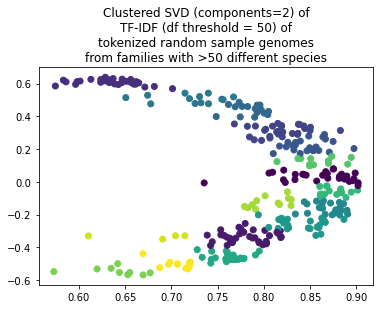

In [26]:

# print(labels)

plt.scatter(data[:,0], data[:,1], c=labels)
plt.title("Clustered SVD (components=2) of\nTF-IDF (df threshold = 50) of\ntokenized random sample genomes\nfrom families with >50 different species")


In [24]:
#checking for label accuracy
families_dict = dict(zip(list(samples['family'].unique()),np.arange(len(samples['family'].unique()))))
hits = 0
for i in range(len(samples['family'])):
    if(labels[i] == families_dict[samples['family'][i]]):
        hits+=1
print("Accuracy: {:.2f}%".format(100 * hits/len(samples['family'])))


Accuracy: 0.31%


In [25]:
#For each family, count how many species fit each label
from math import floor
cluster_num = len(samples['family'].unique())
# match_dict = dict(zip(np.arange(len(samples['family'].unique())), [[0] * len(samples['family'].unique())]* len(samples['family'].unique())))
# matches = [[0]*len(samples['family'].unique())]*len(samples['family'].unique())
matches = np.zeros([cluster_num, cluster_num])
for i in range(0, len(labels), 20):
    cluster = labels[i:i+20]
    idx = floor(i/20)
#     print(matches[idx][0])
    for j in range(len(cluster)):
#         print(cluster[j])
        
        matches[idx][cluster[j]] +=1
#     break
#     print(matches[idx])
print(matches)

#     break
# print(matches)

[[ 0.  0. 11.  0.  0.  0.  1.  0.  0.  0.  0.  0.  8.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  6.  1.  0.  0.  0.  7.  0.  3.  1.  0.  0.]
 [ 0.  0.  0.  0. 11.  0.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [18.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2. 18.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. 19.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]
 [ 0.  2.  8.  0.  1.  3.  1.  0.  0.  0.  2.  0.  2.  1.  0.  0.]
 [ 3.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. 16.  0.  0.  0.  0.]
 [ 0.  7.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  1.  8.  0.  0.]
 [ 8.  0.  0.  0.  0.  5.  0.  0.  0.  5.  0.  0.  2.  0.  0.  0.]
 [ 6.  0.  0.  0.  0.  1.  0.  0.  0. 13.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 16.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0. 17.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 11.  0.  0.  0.  0.  0.  0.  0.  0.  8.  0.  1.  0.  0. 

In [26]:
#checking labels
for i in range(0, len(labels), 20):
    print(labels[i:i+20])

[ 6 12  2  2 12  2  2  2 12 12 12  2  2  2  2  2 12 12 12  2]
[ 5 10  6  5  5  5 10  1 10 10 10  5  2 13  5 10 12 12 10 12]
[4 6 4 6 4 4 6 6 4 4 4 6 6 6 4 4 4 4 6 6]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2]
[7 7 7 6 7 7 7 7 7 7 7 7 7 7 7 7 6 7 7 7]
[14 14 14 14 14 14 14 14 14  9 14 14 14 14 14 14 14 14 14 14]
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
[ 6  5  2  4  5 10  2 12  2  2 10 13  1 12  2  1  2  5  2  2]
[11 11 11  0 11 11  2  0 11 11 11  0 11 11 11 11 11 11 11 11]
[13 13 13 13  1  1 12 13 13 13  5  1  1  1  1 13  5  5  5  1]
[ 9  5  5  0  5  9  0  0 12  5  0  0  0 12  5  9  9  0  0  9]
[9 0 0 0 9 9 5 9 9 9 0 0 9 9 9 9 9 9 0 9]
[3 6 3 3 3 3 3 3 3 3 6 6 3 3 3 3 3 3 6 3]
[8 8 8 8 2 8 8 8 8 8 2 8 8 8 8 8 2 8 8 8]
[ 1 10 10 10  1  1  1  1 12 10 10  1 10  1 10  1  1  1  1 10]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


CPU times: user 267 ms, sys: 13 ms, total: 280 ms
Wall time: 361 ms


Text(0.5, 1.0, 'Cluster identity rates for 20 randomly sampled\nspecies from 16 families')

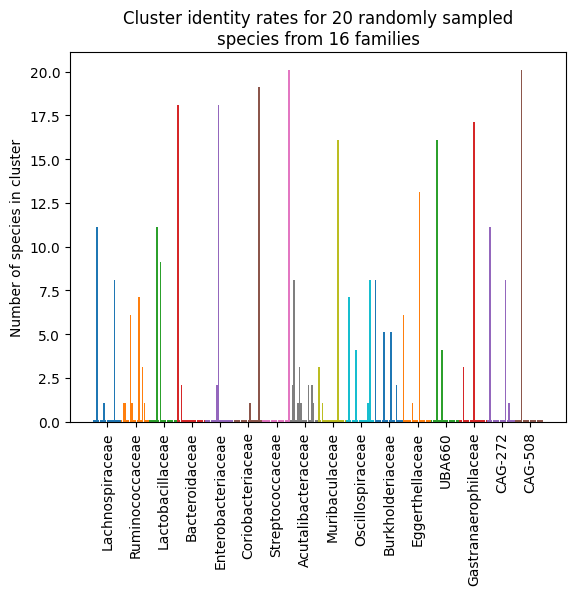

In [27]:
%%time
cluster_num = 16
start_num = 0
for i in range(0, 16):
#     f = plt.figure(i)
    
#     print(matches[i][start_num:start_num +cluster_num])
    plt.bar(np.arange(cluster_num) + i * (cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)

#     plt.bar(np.arange(cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)
#     plt.title("Cluster rates of " + samples['family'].unique()[i] + ', SVD components=2')
#     plt.xticks(np.arange(16))
#     plt.xlabel("Cluster number")
#     plt.yticks(np.arange(20)+1)
#     plt.ylabel("Number of species in cluster")

#     f.show()
    
plt.xticks(np.arange(cluster_num) *cluster_num + floor(cluster_num/2), samples['family'].unique()[start_num:start_num + cluster_num], rotation=90)
plt.ylabel("Number of species in cluster")
plt.title("Cluster identity rates for 20 randomly sampled\nspecies from 16 families")
#plt.legend(samples['family'].unique(), loc='best')

In [ ]:
%%time
cluster_num = 16
start_num = 0
for i in range(0, 16):
    f = plt.figure(i)
    
#     print(matches[i][start_num:start_num +cluster_num])
#     plt.bar(np.arange(cluster_num) + i * (cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)

    plt.bar(np.arange(cluster_num), matches[i][start_num:start_num +cluster_num]+.1, .9, label=i)
    plt.title("Cluster rates of " + samples['family'].unique()[i])
    plt.xticks(np.arange(16))
    plt.xlabel("Cluster number")
    plt.yticks(np.arange(20)+1)
    plt.ylabel("Number of species in cluster")

#     f.show()
    

CPU times: user 1.55 s, sys: 9.04 ms, total: 1.56 s
Wall time: 1.57 s


In [ ]:
beep.beep()

In [38]:
order_family_dict = {'RF39':'UBA660', 'TANB77':'CAG-508'}
cag_uba = unique_species[unique_species['family'].isin(['CAG-508', 'UBA660'])]
for i in range(len(cag_uba)):
    order = cag_uba['order'][i]
    family = cag_uba['family'][i]
    if(order_family_dict[order]!=family):
        print(cag_uba.iloc[i])


In [43]:
for i in range(0, len(labels), 20):
    print(labels[i:i+20])


[15  2  4  6  4 14 10  6  4  8  4 10 10 10 14 10 12  2  8 10]
[ 1  8  7 11  1  1 12  0 12 12 10  3  6  1 11 12  8 12 12  2]
[14  6  8  6  4  4  6 15  4  4  0  7 15  6  8 10  4  2  6  6]
[ 4  2  2  8 12  0  8 12  2  2  2  4  0  0 10  8  2  2 14  4]
[13  2 11 14  0 13 13 13  0  2 11  2 13 13  2  2 14  0 13  0]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 6 10  6 10  6  6  6  6 15 10 10  6 10  6 10  6  6  6  6 10]
[ 7 13 14 12 11 12  6 12 10  6 12  0 13  2 10  0  6  3  6  6]
[11 11  0  2  0  0 10  2  8  0  0  8  0 11  1  1 13  0 13 13]
[ 1  1  1  1  1  1  2  1  1  1  1  1  1  1 11  1  1  3  3 11]
[11  9 11  0  3  9  4  2  0  9  8 13  8  8 11  9  3  2 13  3]
[ 9  0  1 12  3  3  3  3  9  3  2  2 11  3  3  9  3  9  0  3]
[5 6 5 5 5 5 5 5 5 5 7 7 5 5 5 5 5 5 7 5]
[ 7  7  7 15  6 15 15  7  7 15  6  7 15  7 15 15  6  7  6 15]
[ 1 12 10  8  1  1  1  0  2  8  8  1 10  1  8  0  1  0  1  8]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [16]:
print([0]*10)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [152]:
basket = [2, 65, 34, 2, 1, 7, 8]
sorted(basket)

[1, 2, 2, 7, 8, 34, 65]

In [4]:
%%time
np.random.seed(42)
# %%timeit
# for name in df.index[[np.random.randint(0,100000) for i in range(5)]]:
#     write_seq_from_gff(name, os.path.join(path, 'genomes'))
# for name in df.index[:5]:
#     with(open(os.path.join(path, 'genomes', name + '.txt'))) as f:
#         for line in f:
#             print(len(line))
# tokenize = partial(tokenize_with_length_threshold, length_threshold = 10)

for i in range(10):
    genome = read_seq_from_txt(df.index[np.random.randint(1000)], os.path.join(path, 'genomes'))
    tokens = bpe.encode(genome, output_type=yttm.OutputType.SUBWORD)
#     tokens = tokenize(genome)
#     genome = retrieve_genome_from_genome_name(df.index[np.random.randint(1000)])
print(tokens[:100])

['▁GTTTTT', 'TATACGGATTT', 'AAAATCC', 'AAGAGTC', 'TGGACAGTC', 'TACTTC', 'TCTCTAT', 'AACTAT', 'AAAAAATAGC', 'TATGAAAAAATC', 'TATCGTCAT', 'AGATTTC', 'TTCATAGC', 'TAATCTT', 'AGTAT', 'GTTTTATAT', 'AAAGTTT', 'AATCTTTATTC', 'GGTATGAATAT', 'TAGATTAAT', 'TATTGT', 'TATCGTCTC', 'AGCTAT', 'AAGCTTTT', 'AACATTGAAAAAAT', 'TAAAAAT', 'ATATACTTTT', 'AAATAC', 'TAATACTT', 'AGAAAATC', 'TAGATAAGC', 'TATTTAAT', 'TTGTAAT', 'AAGCGTAT', 'TAAATTTATAAAAAT', 'GATTTATC', 'GTGTGAATTC', 'ACCCTT', 'GAATTTTC', 'AGTATATTTTAAAA', 'AATC', 'TAAAATAT', 'TGGTTTACAT', 'AGATATAT', 'TGTCTAT', 'GTATAATGAA', 'AACATATCAAT', 'TGAAT', 'AAGATTTTGAT', 'GAGGCGCATC', 'AATCATGAGT', 'AAACTT', 'TAGATAATTT', 'GTCTGC', 'TAACAATTAT', 'AGAGT', 'TAAAAGGGT', 'GAGATGCC', 'GAAATGAT', 'TCATAATAGC', 'AGTTAT', 'GAATCGTTGG', 'ACTTAATGGT', 'TAAGAGCTAT', 'AAGTTTGTC', 'ATTATTAT', 'TAAATAAT', 'GGAGTGCATC', 'ACTTGTACAT', 'AAATGT', 'AGAACAAGTTC', 'GGCATTCC', 'GAACTT', 'GTTCTTTTTT', 'ATACTGT', 'GTATGTCTCCTC', 'TAATTAT', 'AGGAGGAC', 'TGAAATTGAAT', 'AGAAGTGTT

### Get unique values for class distribution

In [36]:
# print((df['Species_rep'].value_counts().index))
for i in range(10):
#     print(get_clades(df['Species_rep'].value_counts().index[i]+".gff", df)[-1] + " " + str(df['Species_rep'].value_counts()[i]) )
    print(df['Species_rep'].value_counts()[i])
print(df['Species_rep'].value_counts().index[0])
print(df['Species_rep'].value_counts()[:75].sum())

8314
7511
6001
5767
5043
4712
3764
3324
3272
3164
MGYG000002506
152290


In [12]:
import os
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
gffs = sorted(os.listdir(path + "/gffs"), reverse=True)
# print((gffs[:10]))
seqs = sorted(os.listdir(path + '/genomes'), reverse=True)
print(seqs[:2])
print(178115-177950)

['MGYG000178115.txt', 'MGYG000178114.txt']
165


### Assemble filenames

In [70]:
#does not include files with .1
all_files = []
for i in range(1, 4906):
    file = 'MGYG00000' + ("000" + str(i))[-4:] + ".fna"
    if(get_species_status(file, df)):
        all_files.append(file)
print(len(all_files))



3641
CPU times: user 627 ms, sys: 3.99 ms, total: 631 ms
Wall time: 631 ms


In [7]:
all_files = [file + ".fna" for file in df['Species_rep'].unique()] 
print(len(all_files))


4744


In [20]:
### Testing tokenization script
files = os.listdir(os.path.join(path, 'gffs'))
files = [file[:-4] for file in files]
lineages = df['Lineage']
lineages[0]

'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__GCA-900066495;s__GCA-900066495 sp902362365'

In [ ]:
def select_df(df, idx, length = 5000):
    idx = idx * length
    if(idx + length>len(df[idx:])):
        return df[idx:]
    else:
        return df[idx:idx + length]
def tokenize_df(df, idx, bpe, path):
    df['Tokenization']=df.index.map(bpe.encode)
    df['Tokenization'].to_csv(os.path.join(path, 'genome_tokenizations_test_{}'.format(idx)))
    

In [258]:
%%time
total_genome_count = 0
species = [file[:-4] for file in all_files]
print(len(df[df.Species_rep.isin(species)]))


289232
CPU times: user 68.7 ms, sys: 988 µs, total: 69.7 ms
Wall time: 68.7 ms


### Select random files


In [6]:
files = [all_files[np.random.randint(len(all_files))]for i in range(10)]
# print(files[0][:-4])
print(files)
names = [get_name_from_file(file, df) for file in files]
names

NameError: name 'all_files' is not defined

### Retrieve Genomes

In [5]:
%%time
all_genomes = [''.join(list(retrieve_genomes(os.path.join('fastas', file)).values())) for file in files]
print(files[0])
print(len(all_genomes[0]))


NameError: name 'files' is not defined

# Inspecting GFFs


In [387]:
import pprint
from BCBio.GFF import GFFExaminer
from BCBio import GFF
from Bio import  SeqRecord
from Bio import Seq
in_file = os.path.join('gffs', os.listdir('gffs')[0])
print()
examiner = GFFExaminer()
in_file = os.path.join('gffs', os.listdir('gffs')[0])
in_handle = open(in_file)
# print(len("".join([str(rec.seq) for rec in GFF.parse(in_handle)])))
for rec in GFF.parse(in_handle):
#     print(rec.seq[:100])
    print(rec)
    break
    
in_handle.close()




ID: MGYG000005934.fa_1
Name: <unknown name>
Description: <unknown description>
Number of features: 86
/gff-version=['3']
/sequence-region=[('MGYG000005934.fa_1', 0, 84762), ('MGYG000005934.fa_2', 0, 76826), ('MGYG000005934.fa_3', 0, 53081), ('MGYG000005934.fa_4', 0, 51457), ('MGYG000005934.fa_5', 0, 51126), ('MGYG000005934.fa_6', 0, 48699), ('MGYG000005934.fa_7', 0, 47102), ('MGYG000005934.fa_8', 0, 41906), ('MGYG000005934.fa_9', 0, 38605), ('MGYG000005934.fa_10', 0, 38014), ('MGYG000005934.fa_11', 0, 37689), ('MGYG000005934.fa_12', 0, 36349), ('MGYG000005934.fa_13', 0, 32483), ('MGYG000005934.fa_14', 0, 32252), ('MGYG000005934.fa_15', 0, 32184), ('MGYG000005934.fa_16', 0, 29789), ('MGYG000005934.fa_17', 0, 29123), ('MGYG000005934.fa_18', 0, 28773), ('MGYG000005934.fa_19', 0, 27342), ('MGYG000005934.fa_20', 0, 26212), ('MGYG000005934.fa_21', 0, 25970), ('MGYG000005934.fa_22', 0, 23504), ('MGYG000005934.fa_23', 0, 22446), ('MGYG000005934.fa_24', 0, 22339), ('MGYG000005934.fa_25', 0, 20

In [247]:
in_file = os.path.join('gffs', os.listdir('gffs')[0])
genome = retrieve_genome_from_gff(in_file)
tokens = tokenize_with_length_threshold(tokens, length_threshold=0)
print(len(tokens))

351149


In [251]:
##Selecting random data
# print(os.listdir('gffs')[0][:-4])


MGYG000003574


In [208]:
genera = set()
families = set()
orders = set()
classes = set()
phyla = set()
domains = set()
print(len(df))
for lineage in df['Lineage'].unique():
    #genuses
    g_start_idx = lineage.find("g__") + len('g__')
    g_end_idx = lineage[g_start_idx:].find(';') + g_start_idx
    genera.add(lineage[g_start_idx:g_end_idx])
    #families
    f_start_idx = lineage.find("f__") + len('f__')
    f_end_idx = lineage[f_start_idx:].find(";") + f_start_idx
    families.add(lineage[f_start_idx:f_end_idx])
    #orders 
    o_start_idx = lineage.find("o__") + len('o__')
    o_end_idx = lineage[o_start_idx:].find(";") + o_start_idx
    orders.add(lineage[o_start_idx:o_end_idx])
    #classes
    c_start_idx = lineage.find("c__") + len('c__')
    c_end_idx = lineage[c_start_idx:].find(";") + c_start_idx
    classes.add(lineage[c_start_idx:c_end_idx])
    #phyla
    p_start_idx = lineage.find("p__") + len('p__')
    p_end_idx = lineage[p_start_idx:].find(";") + p_start_idx
    phyla.add(lineage[p_start_idx:p_end_idx])
    #domains
    d_start_idx = lineage.find("d__") + len('d__')
    d_end_idx = lineage[d_start_idx:].find(";") + d_start_idx
    domains.add(lineage[d_start_idx:d_end_idx])

print("Clade counts:")
print("Domains: "+str(len(domains)))
print("Phyla: "+str(len(phyla)))
print("Classes: " + str(len(classes)))
print("Orders: "+ str(len(orders)))
print("Families: " + str(len(families)))
print("Genera: " + str(len(genera)))
print("Species: " + str(len(df['Lineage'].unique())))
    
    

289232
Clade counts:
Domains: 2
Phyla: 24
Classes: 34
Orders: 92
Families: 214
Genera: 1031
Species: 3910


In [207]:
pd.set_option("display.max_rows", None)
print(df['Country'].value_counts())
pd.set_option("display.max_rows", 10)


China                          57778
United States                  49889
Denmark                        28410
Spain                          21386
Sweden                         19705
Israel                         17617
United Kingdom                 12626
Fiji                           10799
Netherlands                    10213
Austria                         9643
Germany                         8442
Kazakhstan                      5305
Finland                         5286
Mongolia                        5257
France                          4025
Canada                          3996
Russia                          3053
Estonia                         2821
Peru                            1947
Madagascar                      1734
Italy                           1233
United Republic of Tanzania     1177
Japan                            905
Bangladesh                       745
Australia                        615
El Salvador                      477
not provided                     363
B

# Inspecting Dataset for rank/frequency trends

## Tokenizing - Doc2Vec (Toy Example)

### Testing Tokenization Thresholds

In [135]:
%%time
np.random.seed(42)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
sample_df = df.iloc[[np.random.randint(0, 1000) for i in range(10)]]
thresholds = [0]#, 10, 20, 30, 40, 50]
for threshold in thresholds:
#     tokenize = partial(tokenize_with_length_threshold, length_threshold = threshold)
    print("Threshold:",threshold)
    for i, name in enumerate(sample_df.index):
        genome = read_seq_from_txt(name, os.path.join(path, 'genomes'))
#         tokens = tokenize(genome)
        tokens = bpe.encode(genome, output_type=yttm.OutputType.SUBWORD)
        print(name, get_name_from_file(name + '.gff', sample_df) + ":", len(tokens))

Threshold: 0
MGYG000000103 B. massiliensis: 520421
MGYG000000437 A. sp001941065: 385599
MGYG000000865 C. sp900554255: 180954
MGYG000000271 R. sp900552665: 422398
MGYG000000107 K. oxytoca: 685553
MGYG000000072 U. sp900066845: 304159
MGYG000000705 C. sp000434435: 192859
MGYG000000021 L. vaginalis_A: 230675
MGYG000000617 RUG410 [none]: 181707
MGYG000000122 S. epidermidis: 297303
CPU times: user 30.2 s, sys: 151 ms, total: 30.3 s
Wall time: 33.1 s


In [85]:
%%time
np.random.seed(42)
def read_corpus(df, tokens_only=False, length_threshold=0):
    for i, name in enumerate(df['Genome']):
        genome = retrieve_genome_from_gff(os.path.join(path, 'gffs', name + '.gff'))
        tokens = tokenize(length_threshold=length_threshold)
        if(tokens_only):
            yield tokens
        else:
            # For training data, add tags
            yield (gensim.models.doc2vec.TaggedDocument(tokens, [i]), dtype='object')
sample_df = df.iloc[[np.random.randint(0, 100000) for i in range(500)]]
train, test = train_test_split(sample_df, test_size=.1)

train_corpus = read_corpus(train)
print("listizing train_corpus")

train_corpus = list(train_corpus)
test_corpus = (read_corpus(test, tokens_only=True))
print('listizing test_corpus')
test_corpus = list(test_corpus)


SyntaxError: invalid syntax (<unknown>, line 5)

In [84]:
%%time
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)


AttributeError: 'numpy.ndarray' object has no attribute 'words'

In [367]:
# Inspecting Dataset for rank/frequency trends

## Tokenizing

In [367]:
# Inspecting Dataset for rank/frequency trends

## Tokenizing

In [60]:
%%time
model.train(list(train_corpus), total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 24.2 ms, sys: 14 ms, total: 38.2 ms
Wall time: 29.5 ms


In [64]:
ranks = []
second_ranks = []
train_corpus = list(train_corpus)
print(len(list(train_corpus)))
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

0


In [63]:
import collections

counter = collections.Counter(ranks)
print(counter)


Counter()


In [374]:
%%time
from ast import literal_eval
import pickle
from math import floor
### Testing section rewrite
test_df = df[:50]   
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
for name in test_df.index:
    seq = retrieve_genome_from_genome_name(name)
    tokenization = np.array(bpe.encode(seq))
    np.save(os.path.join(path, 'tokenizations', name + '.npy'), tokenization)
    
# test_df['Seq'] = test_df.index.map(retrieve_genome_from_genome_name)
# test_df['Tokenization']=test_df['Seq'].apply(lambda s: np.array(bpe.encode(s)))
# print(type(test_df['Tokenization'][0]))

# denom = 5
# path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/tokenizations/genome_tokenizations_test_'
# idx = 7
# name = df.index[idx]
# file_idx = str(floor(idx/denom))
# test_df =pd.read_csv(path + file_idx+ '.tsv', index_col = 0, delimiter = '\t')
# tokenization = test_df.loc[name]['Tokenization']
# tokenization = literal_eval(tokenization)



KeyboardInterrupt: 

Process ForkPoolWorker-184:
Process ForkPoolWorker-183:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/gpfs/home/jic286/.conda/envs/imblearn_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs/ho

# Checking .npy read speeds

In [3]:
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
df

,Genome,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
0,MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.70,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
1,MGYG000000002,Isolate,4433109,101,109267,42.60,99.37,0.00,82.35,95.37,86.19,19,GUT_GENOME000004,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS370064,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
2,MGYG000000003,Isolate,3229518,35,158570,58.52,100.00,0.00,94.96,99.67,99.66,20,GUT_GENOME000008,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,ERS370070,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
3,MGYG000000004,Isolate,3698896,105,90297,54.19,98.66,0.22,93.28,99.67,99.83,20,GUT_GENOME000010,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS370072,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
4,MGYG000000005,Isolate,3930428,32,350032,28.59,99.30,0.00,89.08,99.67,99.83,20,GUT_GENOME000017,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS417217,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289227,MGYG000289389,MAG,2401111,16,227958,45.09,97.58,0.24,0.00,0.00,5.47,14,GUT_GENOME155261,MGYG000000280,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS475251,ERP005860,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
289228,MGYG000289390,MAG,1083388,311,3789,45.91,67.48,1.50,0.00,0.00,0.00,17,GUT_GENOME110173,MGYG000004337,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o...,ERS328872,ERP003612,Denmark,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
289229,MGYG000289391,MAG,2202510,153,20278,44.45,94.07,0.84,93.28,0.00,0.00,16,GUT_GENOME024976,MGYG000000669,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS1444564,ERP019502,Kazakhstan,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
289230,MGYG000289392,MAG,2098263,28,154333,37.46,92.62,0.00,0.00,60.14,72.31,16,GUT_GENOME205194,MGYG000001319,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,SRS1996016,SRP100518,Spain,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


In [6]:
from tables import open_file
from tqdm import tqdm
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
tknz_path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/tokenizations'
file = open_file(path_to_db, 'r')
data = file.root.data
sample_data = df.sample(1000, random_state = 42)
sample_data
for idx in tqdm(sample_data.index):
    tkns = data['Tknz%d' % idx].read()
    tkns = np.save(os.path.join(tknz_path, str(idx) + ".npy"), np.array(tkns)) 
beep.beep(secs=1)
# file.close()

100%|██████████| 1000/1000 [02:27<00:00,  6.76it/s]


In [7]:
from time import time
start_time = time()
tokenizations = []
for idx in sample_data.index:
    tkns = np.load(os.path.join(tknz_path, str(idx) + ".npy"))
    tokenizations.append(tkns)
print((time()-start_time)/len(tokenizations))
beep.beep(secs=1)

0.016870543479919432


In [8]:
tokenizations = []
start_time = time()
for idx in sample_data.index:
    tkns = data['Tknz%d' % idx].read()
    tokenizations.append(tkns)
print((time()-start_time)/len(tokenizations))
beep.beep(secs=1)

0.045358112573623655


In [383]:
%%time
tokenization = np.load(os.path.join(path, 'tokenizations', name + '.npy'))
tokenization[:10]


CPU times: user 2.34 ms, sys: 1.07 ms, total: 3.4 ms
Wall time: 2.6 ms


array([ 122342,  272700, 1684803,  517466,    5546,  904658,     232,
         37454,     101,   46030])

### Messing around with multiprocessing

In [355]:
%%time
from multiprocessing import Process


def print_func(continent='Asia'):
    pass
    print('The name of continent is : ', continent)

if __name__ == "__main__":  # confirms that the code is under main function
    names = ['America', 'Europe', 'Africa']
    procs = []
    proc = Process(target=print_func)  # instantiating without any argument
    procs.append(proc)
    proc.start()

    # instantiating process with arguments
    for name in names:
        # print(name)
        proc = Process(target=print_func, args=(name,))
        procs.append(proc)
        proc.start()

    # complete the processes
    for proc in procs:
        proc.join()


The name of continent is :  The name of continent is : Asia
 The name of continent is : America 
Europe
The name of continent is :  Africa
CPU times: user 11.6 ms, sys: 190 ms, total: 202 ms
Wall time: 306 ms


In [358]:
from multiprocessing import Queue

colors = ['red', 'green', 'blue', 'black']
cnt = 1
# instantiating a queue object
queue = Queue()
print('pushing items to queue:')
for color in colors:
    print('item no: ', cnt, ' ', color)
    queue.put(color)
    cnt += 1

print('\npopping items from queue:')
cnt = 1
while not queue.empty():
    print('item no: ', cnt, ' ', queue.get())
    cnt += 1


pushing items to queue:
item no:  1   red
item no:  2   green
item no:  3   blue
item no:  4   black

popping items from queue:
item no:  1   red
item no:  2   green
item no:  3   blue
item no:  4   black


In [360]:

from multiprocessing import Pool

import time

work = (["A", 5], ["B", 2], ["C", 1], ["D", 3])


def work_log(work_data):
    print(" Process %s waiting %s seconds" % (work_data[0], work_data[1]))
    time.sleep(int(work_data[1]))
    print(" Process %s Finished." % work_data[0])


def pool_handler():
    p = Pool(2)
    p.map(work_log, work)


if __name__ == '__main__':
    pool_handler()


 Process A waiting 5 seconds Process B waiting 2 seconds

 Process B Finished.
 Process C waiting 1 seconds
 Process C Finished.
 Process D waiting 3 seconds
 Process A Finished.
 Process D Finished.


In [377]:
%%time
from multiprocessing import Pool
test_df = df[:50]
def tokenize_from_name(name):
    seq = retrieve_genome_from_genome_name(name)
    tokens = np.array(bpe.encode(seq))
    np.save(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/tokenizations', name), tokens)
def pool_handler():
    p = Pool(40)
    p.map(tokenize_from_name, test_df.index)
pool_handler()


CPU times: user 175 ms, sys: 2.28 s, total: 2.46 s
Wall time: 43.8 s


In [107]:
print(len(os.listdir('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs')))

286419


# FTP/download test

In [67]:
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
filepath = 'pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/'
ftp.cwd(filepath)
print(ftp.pwd())
def getFile(ftp, filename):
    ftp.retrbinary("RETR " + filename,open(os.path.join(filepath, filename), 'wb').write )

# getFile(ftp,"MGYG0000001/MGYG000000112/genomes1/MGYG000000112.gff.gz")
ftp.quit()

for line in data[:10]:
    print("-", line)
print(len(data))

/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes
- drwxr-xr-x  101 ftp      ftp          3069 Dec 07  2021 MGYG0000000
- drwxr-xr-x  102 ftp      ftp          3100 Dec 07  2021 MGYG0000001
- drwxr-xr-x  102 ftp      ftp          3100 Dec 07  2021 MGYG0000002
- drwxr-xr-x   98 ftp      ftp          2976 Dec 07  2021 MGYG0000003
- drwxr-xr-x  101 ftp      ftp          3069 Dec 07  2021 MGYG0000004
- drwxr-xr-x  101 ftp      ftp          3069 Dec 07  2021 MGYG0000005
- drwxr-xr-x  100 ftp      ftp          3038 Dec 07  2021 MGYG0000006
- drwxr-xr-x  101 ftp      ftp          3071 Dec 07  2021 MGYG0000007
- drwxr-xr-x   86 ftp      ftp          2604 Dec 07  2021 MGYG0000008
- drwxr-xr-x   96 ftp      ftp          2914 Dec 07  2021 MGYG0000009
50


In [124]:
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
filepath = 'pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/'
import sys
import ftplib
import os
from ftplib import FTP
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
filepath = '/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/'
ftp.cwd(filepath)
os.chdir(path)
def downloadFiles(path,destination):
    print(ftp.pwd())

#path & destination are str of the form "/dir/folder/something/"
#path should be the abs path to the root FOLDER of the file tree to download
    try:

        ftp.cwd(path)
#         #clone path to destination
        os.chdir(destination)
        os.mkdir(destination[0:len(destination)-1]+path)
        print (destination[0:len(destination)-1]+path+" built")
    except OSError:
#         #folder already exists at destination
        pass
    except ftplib.error_perm:
#         #invalid entry (ensure input form: "/dir/folder/something/")
        print ("error: could not change to "+path)
        sys.exit("ending session")

    #list children:
    filelist=ftp.nlst()
    
    for file in filelist:
        try:
            #this will check if file is folder:
            ftp.cwd(path+file+"/")
            #if so, explore it:
            downloadFiles(path+file+"/",destination)
        except ftplib.error_perm:
            #not a folder with accessible content
            #download & return
            os.chdir(destination[0:len(destination)-1]+path)
            #possibly need a permission exception catch:
            with open(os.path.join(destination,file),"wb") as f:
                ftp.retrbinary("RETR "+file, f.write)
            print (file + " downloaded")
    return


source="/MGYG0000001/MGYG000000112/genomes1/"
dest = os.getcwd()+ '/'
downloadFiles( source, dest)


/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes


error_perm: 550 Failed to change directory.

In [130]:
###This is the one that works
from contextlib import closing
from urllib.request import urlopen

url = 'ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000031/MGYG000003137/genomes1/MGYG000223221.gff.gz'
target_path = 'fastas/MGYG000223221.gff.gz'

with closing(urlopen(url)) as source:
    with open(target_path, 'wb') as target:
        target.write(source.read())

In [187]:
###This is the one that works
from contextlib import closing
from urllib.request import urlopen
import pandas as pd
import os
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
for i in range(len(df['FTP_download'])+1):
    
    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    with closing(urlopen(url)) as source:
        with gzip.open(source) as f:
            with open(os.path.join('gffs',target_path), 'wb') as target:
                target.write((f.read()))
#                 for line in f.readlines():
#                     target.write(line)
    break
with(open(os.path.join('gffs',target_path), 'rb')) as target:
    print(str(target.readlines()[0][:100], encoding='utf-8'))

##gff-version 3



path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
gff_files = os.listdir(os.path.join(path, 'gffs'))
for i in range(len(df['FTP_download'])+1):
    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    if(target_path not in gff_files):
        print(target_path)

In [17]:
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
gff_files = sorted(os.listdir(os.path.join(path, 'gffs')))
for i in range(1, len(gff_files)+1):
    file_num = gff_files[i]
    file_num = int(file_num[4:file_num.rfind('.')])
    if file_num !=i+1 and file_num !=341:
        print(gff_files[i])
        print(file_num)
        print(i)
        break

MGYG000000342.gff
342
340


In [19]:
###This is the one that works
from contextlib import closing
from urllib.request import urlopen
import gzip
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
for i in range(94460, 289233):

    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    connected= False
    while not connected:
        try:
            with closing(urlopen(url)) as source:
                with gzip.open(source) as f:
                    with open(os.path.join('gffs',target_path), 'wb') as target:
                        target.write((f.read()))
                        connected=True
        except:
            connected=False
# print("All content downloaded")
#def download_gff(url):
#    target_path = url[url.rfind('/')+1:-3]
#    connected= False
#    while not connected:
#        try:
#            with closing(urlopen(url)) as source:
#                with gzip.open(source) as f:
#                    with open(os.path.join('gffs',target_path), 'wb') as target:
#                        target.write((f.read()))
#                        connected=True
#         except:
#             connected=False
#def pool_handler(df):
#    p = Pool(40)
#    p.map(download_gff, df['FTP_download'][94478:])

#if __name__=="__main__":
#    path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
#    os.chdir(path)
#    df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
#    pool_handler(df)
#    print("All content downloaded")




SyntaxError: default 'except:' must be last (2156025061.py, line 22)

In [54]:
###TEST
from contextlib import closing
from urllib.request import urlopen
import gzip
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
df.loc[missing[0]]['FTP_download']

'ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002545/genomes2/MGYG000178116.gff.gz'

In [5]:
%%time
###This is the one that works
from contextlib import closing
from urllib.request import urlopen
import gzip
import pandas as pd
import os
from multiprocessing import cpu_count, Pool
path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
os.chdir(path)
df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t', index_col=0)
for i in range(len(missing)):

    url = df.loc[missing[i]]['FTP_download']
    print(url)
    target_path = url[url.rfind('/')+1:-3]
    connected= False
    while not connected:
        try:
            with closing(urlopen(url)) as source:
                with gzip.open(source) as f:
                    with open(os.path.join('gffs',target_path), 'wb') as target:
                        target.write((f.read()))
                        connected=True
        except:
            connected=False
print("All content downloaded")
#def download_gff(url):
#    target_path = url[url.rfind('/')+1:-3]
#    connected= False
#    while not connected:
#        try:
#            with closing(urlopen(url)) as source:
#                with gzip.open(source) as f:
#                    with open(os.path.join('gffs',target_path), 'wb') as target:
#                        target.write((f.read()))
#                        connected=True
#def pool_handler(df):
#    p = Pool(40)
#    p.map(download_gff, df['FTP_download'][94478:])

#if __name__=="__main__":
#    path ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
#    os.chdir(path)
#    df = pd.read_csv(os.path.join(path, 'genomes-all_metadata.tsv'), sep='\t')
#    pool_handler(df)
#    print("All content downloaded")




ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000009/MGYG000000979/genomes1/MGYG000243109.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000022/genomes2/MGYG000243110.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001359/genomes1/MGYG000243111.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000236/genomes1/MGYG000243112.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000029/MGYG000002993/genomes1/MGYG000243113.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004196/genomes1/MGYG000243114.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000003/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000243166.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000507/genomes1/MGYG000243167.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000007/MGYG000000725/genomes1/MGYG000243168.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001380/genomes2/MGYG000243169.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000046/MGYG000004612/genomes1/MGYG000243170.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002060/genomes1/MGYG000243171.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000190/genomes2/MGYG000243223.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000006/MGYG000000644/genomes1/MGYG000243224.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000243225.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000243226.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000040/MGYG000004059/genomes1/MGYG000243227.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002538/genomes1/MGYG000243228.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002470/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000254/genomes2/MGYG000247071.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000562/genomes1/MGYG000247072.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247073.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000122/genomes1/MGYG000247074.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000018/genomes1/MGYG000247075.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001313/genomes1/MGYG000247076.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000004/MGYG000000431/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000247128.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG000247129.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000144/genomes3/MGYG000247130.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001338/genomes2/MGYG000247131.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001337/genomes1/MGYG000247132.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002396/genomes1/MGYG000247133.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG000247185.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247186.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000193/genomes1/MGYG000247187.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247188.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000038/MGYG000003899/genomes1/MGYG000247189.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002530/genomes2/MGYG000247190.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004337/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000017/MGYG000001737/genomes1/MGYG000247242.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002445/genomes1/MGYG000247243.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247244.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002321/genomes3/MGYG000247245.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000041/genomes2/MGYG000247246.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002395/genomes3/MGYG000247247.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003686/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000078/genomes2/MGYG000247299.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000044/genomes2/MGYG000247300.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002366/genomes1/MGYG000247301.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000045/MGYG000004508/genomes1/MGYG000247302.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000015/MGYG000001564/genomes1/MGYG000247303.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247304.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001029/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000247356.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001029/genomes2/MGYG000247357.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003694/genomes3/MGYG000247358.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247359.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000029/MGYG000002926/genomes1/MGYG000247360.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002570/genomes2/MGYG000247361.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000017/MGYG000001756/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000029/MGYG000002994/genomes1/MGYG000247413.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000039/MGYG000003949/genomes1/MGYG000247414.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000247415.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002538/genomes1/MGYG000247416.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG000247417.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000217/genomes2/MGYG000247418.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000243/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000027/MGYG000002773/genomes1/MGYG000247470.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247471.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000060/genomes3/MGYG000247472.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000045/genomes2/MGYG000247473.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000154/genomes1/MGYG000247474.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000019/MGYG000001981/genomes1/MGYG000247475.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002506/genomes8/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000247527.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003683/genomes1/MGYG000247528.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002324/genomes1/MGYG000247529.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000247530.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000014/MGYG000001410/genomes1/MGYG000247531.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000003/MGYG000000362/genomes1/MGYG000247532.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000012/MGYG000001294/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000562/genomes1/MGYG000247584.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000084/genomes2/MGYG000247585.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000037/MGYG000003702/genomes1/MGYG000247586.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000041/genomes2/MGYG000247587.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001029/genomes2/MGYG000247588.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000021/MGYG000002108/genomes1/MGYG000247589.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002506/genomes8/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000030/MGYG000003056/genomes1/MGYG000247641.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000018/MGYG000001866/genomes1/MGYG000247642.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247643.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000006/MGYG000000671/genomes1/MGYG000247644.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000022/MGYG000002293/genomes3/MGYG000247645.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000074/genomes2/MGYG000247646.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000088/genomes1/MGYG000247698.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002303/genomes1/MGYG000247699.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002321/genomes3/MGYG000247700.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001398/genomes1/MGYG000247701.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000004/MGYG000000484/genomes1/MGYG000247702.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002453/genomes1/MGYG000247703.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000003/MGYG000000362/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002478/genomes5/MGYG000247755.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002549/genomes1/MGYG000247756.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000047/MGYG000004769/genomes2/MGYG000247757.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000044/genomes2/MGYG000247758.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247759.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002570/genomes2/MGYG000247760.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001302.1/genomes5/MGYG

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG000247812.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000015/MGYG000001577/genomes1/MGYG000247813.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000177/genomes1/MGYG000247814.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000006/MGYG000000606/genomes1/MGYG000247815.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004158/genomes2/MGYG000247816.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004337/genomes1/MGYG000247817.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000022/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000033/MGYG000003306/genomes1/MGYG000247869.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000217/genomes2/MGYG000247870.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000010/MGYG000001057/genomes1/MGYG000247871.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002021/genomes1/MGYG000247872.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000027/MGYG000002720/genomes1/MGYG000247873.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001319/genomes1/MGYG000247874.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000038/MGYG000003891/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000530/genomes1/MGYG000247926.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004155/genomes1/MGYG000247927.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003681/genomes2/MGYG000247928.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001338/genomes2/MGYG000247929.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004196/genomes1/MGYG000247930.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000014/MGYG000001415/genomes1/MGYG000247931.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003686/genomes2/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000009/MGYG000000941/genomes1/MGYG000247983.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000247984.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000011/MGYG000001178/genomes1/MGYG000247985.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000001/MGYG000000196/genomes1/MGYG000247986.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000060/genomes3/MGYG000247987.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000247988.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000028/MGYG000002876/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000248040.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000248041.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001321/genomes1/MGYG000248042.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000249/genomes1/MGYG000248043.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000000/MGYG000000074/genomes2/MGYG000248044.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000013/MGYG000001374/genomes2/MGYG000248045.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002528/genomes3/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000205/genomes1/MGYG000248097.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000251/genomes3/MGYG000248098.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004345/genomes1/MGYG000248099.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000542/genomes1/MGYG000248100.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000026/MGYG000002616/genomes1/MGYG000248101.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000002/MGYG000000258/genomes4/MGYG000248102.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002060/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000257763.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004138/genomes1/MGYG000257764.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004158/genomes2/MGYG000257765.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000036/MGYG000003694/genomes3/MGYG000257766.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000025/MGYG000002517/genomes1/MGYG000257767.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000005/MGYG000000534/genomes1/MGYG000257768.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000038/MGYG000003875/genomes1/MGYG00

ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000041/MGYG000004111/genomes1/MGYG000257820.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000024/MGYG000002492/genomes7/MGYG000257821.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000020/MGYG000002082/genomes1/MGYG000257822.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000043/MGYG000004351/genomes1/MGYG000257823.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000023/MGYG000002369/genomes1/MGYG000257824.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000019/MGYG000001937/genomes1/MGYG000257825.gff.gz
ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000022/MGYG000002293/genomes3/MGYG00

In [18]:
for i in range(26, len(df['FTP_download'])+1):

    url = df['FTP_download'][i]
    target_path = url[url.rfind('/')+1:-3]
    connected= False
    while not connected:
        try:
            with closing(urlopen(url)) as source:
                with gzip.open(source) as f:
                    with open(os.path.join('gffs',target_path), 'wb') as target:
                        target.write((f.read()))
                        connected=True
        except:
            connected=False


KeyboardInterrupt: 

In [175]:
string ='ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/all_genomes/MGYG0000031/MGYG000003137/genomes1/MGYG000223221.gff.gz'
s = string[string.rfind('/')+1:]
s

'MGYG000223221.gff.gz'

# Getting FASTAs

In [167]:
import os
import ftplib
destination  = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/fastas'
os.chdir(destination)
ftp = ftplib.FTP("ftp.ebi.ac.uk")
ftp.login("anonymous", "foo")
path = '/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue'
# '/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/species_catalogue/MGYG0000000/MGYG000000001/genome'
ftp.cwd(path)
folders = ftp.nlst()
for folder in folders:
    ftp.cwd(folder)#changes to /num7zeroes
    subfolders = ftp.nlst()
    for subfolder in subfolders:
        ftp.cwd(os.path.join(subfolder, "genome"))
        files = ftp.nlst()
        for file in files:
            if ".fna" in file and '.fai' not in file:
                with open(os.path.join(destination,file),"wb") as f:
                    ftp.retrbinary("RETR "+file, f.write)
        ftp.cwd('../..')
    ftp.cwd(path)

        
ftp.close()


KeyboardInterrupt: 

# Checking sequence redundancy

In [13]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))


,file,domain,phylum,class,order,family,genus,species
2492,MGYG000002506.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
4982,MGYG000005018.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
5122,MGYG000005170.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
5141,MGYG000005189.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
5148,MGYG000005196.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
...,...,...,...,...,...,...,...,...
288923,MGYG000289085.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
289068,MGYG000289230.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
289102,MGYG000289264.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D
289157,MGYG000289319.gff,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,E. coli_D


### E. Coli

In [26]:
species = all_species[all_species['species'].isin([all_species['species'].value_counts().index[0]])]

### Investigating Lachnospiraceae

In [37]:
lachnos = all_species[all_species['family'].isin(['Lachnospiraceae'])]
lachnos_counts = lachnos['species'].value_counts()
lachnos_counts[lachnos_counts==1]
lachnos_counts


species
A. rectalis          7511
F. saccharivorans    3272
L. eligens_A         3164
A. faecis            2899
A. hadrus            2841
                     ... 
U. sp900769175          1
B. sp900768755          1
B. sp900556555          1
H. sp900766915          1
KM106-2 [none]          1
Name: count, Length: 441, dtype: int64

### Investigating Bacteroideceae

In [35]:
bacters = all_species[all_species['family'].isin(['Bacteroidaceae'])]
bacter_counts = bacters['species'].value_counts()
len(bacter_counts[bacter_counts==1])

36

In [21]:
from tables import *
from tqdm import tqdm
file = open_file(path_to_db, 'r')
data = file.root.data
species_tokens = []
lens_list = []
lens_sets = []
for idx in tqdm(species.index[:100]):
    tkns = data['Tknz%d' % idx].read()
    lens_list.append(len(tkns))
    species_tokens.append(tkns)
    lens_sets.append(len(set(tkns)))
    


100%|██████████| 100/100 [00:03<00:00, 29.10it/s]


In [24]:
for i, tokens in enumerate(species_tokens):
    print("Array length: {} Set length: {} \n First 20 tokens: {} \n Last 20 tokens: {}".format(lens_list[i], lens_sets[i], tokens[:20], tokens[-20:]))

Array length: 599010 Set length: 226028 
 First 20 tokens: [3014, 175, 25967, 5871, 415, 89905, 34330, 445574, 2908, 487360, 2447, 51980, 40782, 207, 928004, 7476, 442, 40796, 380372, 7906] 
 Last 20 tokens: [2082, 508051, 3449, 81483, 211831, 1364, 163621, 3292, 10049, 3128367, 36910, 30136, 22343, 735, 131882, 24719, 4585024, 4257, 24699, 13]
Array length: 598320 Set length: 227792 
 First 20 tokens: [8979, 421884, 3961, 219682, 4797598, 5424, 939088, 1609140, 3760, 331, 16343, 3148165, 74242, 599453, 380336, 25191, 321, 178253, 1703, 103054] 
 Last 20 tokens: [590719, 28917, 3021318, 256, 15690, 214, 4678, 6656, 4041, 1641936, 37195, 215778, 15942, 585, 36075, 4494, 877716, 7362, 7764769, 843433]
Array length: 548977 Set length: 216041 
 First 20 tokens: [8979, 421884, 3961, 219682, 4797598, 5424, 939088, 1609140, 3760, 331, 16343, 3148165, 74242, 599453, 380336, 25191, 321, 178253, 1703, 103054] 
 Last 20 tokens: [117112, 724, 19630, 9452, 14429, 456, 66745, 1133, 9806, 4235634, 31

In [25]:
print(len(set(lens_list)))

100


### Putting all genomes in one text file

In [18]:
i = 0
for name in df.index:
    print(name)
    print(len(retrieve_genome_from_genome_name(name)))
    break

MGYG000000001
3221717


In [41]:
# print((df[df.Species_rep.str.contains("\.")]))
df[df.Species_rep.str.contains("3331.1")]

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
Genome,,,,,,,,,,,,,,,,,,,


In [69]:
# for name in df.index:
#     filepath = os.path.join(path,'corpora/uhgg_all_genomes_ordered.txt' )
#     print(filepath)
#     with open(filepath, 'a+') as f:
#         genome = retrieve_genome_from_genome_name(name)
#         print(set(list(genome)))
#         f.write(genome + "\n")
#         f.write(genome)
#         break
# with open(filepath, 'r') as f:
#     print(len(f.readlines()))

/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/corpora/uhgg_all_genomes_ordered.txt
{'N', 'A', 'G', 'T', 'C'}
2


In [157]:
%%time

from tqdm import tqdm
unique_reps = []
unique_species = list(df.Lineage.unique())
sample_df = df[df['Lineage'].isin(unique_species)]
print(len(unique_species))
for i in tqdm(range(3911)):
    if len(unique_species)<= 0:
        break
    sample_df = sample_df[sample_df['Lineage'].isin(unique_species)]
    # print(len(sample_df))
    # print(sample_df.Lineage[0])
    sample = sample_df[sample_df.Lineage ==sample_df.Lineage[0]]
    # print(len(sample_df), len(sample), sample.iloc[0].name)
    if sample.iloc[0].name == 'MGYG000000907':
        print(sample)
    unique_reps.append(sample.iloc[0])
    unique_species.pop(unique_species.index(sample.Lineage[0]))
print(len(unique_reps))


3910


 21%|██        | 826/3911 [00:38<02:16, 22.68it/s]

              Genome_type   Length  N_contigs    N50  GC_content  \
Genome                                                             
MGYG000000907         MAG  1602935         62  41170       62.99   

               Completeness  Contamination  rRNA_5S  rRNA_16S  rRNA_23S  \
Genome                                                                    
MGYG000000907         79.74           0.81    94.12     31.38     99.42   

               tRNAs  Genome_accession    Species_rep  \
Genome                                                  
MGYG000000907     17  GUT_GENOME045096  MGYG000000907   

                                                         Lineage  \
Genome                                                             
MGYG000000907  d__Bacteria;p__Actinobacteriota;c__Coriobacter...   

              Sample_accession Study_accession Country Continent  \
Genome                                                             
MGYG000000907       ERS1289708       ERP016813   China  

100%|█████████▉| 3910/3911 [01:42<00:00, 38.12it/s] 

3910
CPU times: user 1min 42s, sys: 289 ms, total: 1min 42s
Wall time: 1min 42s


In [168]:
unique_rep_df = pd.concat(unique_reps, axis=1).T
unique_rep_df.to_csv('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/unique_reps.csv')
unique_rep_df = pd.read_csv('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/unique_reps.csv', index_col=0)
unique_rep_df

,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.70,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000002,Isolate,4433109,101,109267,42.60,99.37,0.00,82.35,95.37,86.19,19,GUT_GENOME000004,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS370064,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000003,Isolate,3229518,35,158570,58.52,100.00,0.00,94.96,99.67,99.66,20,GUT_GENOME000008,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,ERS370070,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000004,Isolate,3698896,105,90297,54.19,98.66,0.22,93.28,99.67,99.83,20,GUT_GENOME000010,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS370072,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000000005,Isolate,3930428,32,350032,28.59,99.30,0.00,89.08,99.67,99.83,20,GUT_GENOME000017,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS417217,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000004884,MAG,2896455,444,8858,50.40,91.65,1.19,0.00,0.00,5.33,13,CAJMMH01,MGYG000004884,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS5599311,ERP120667,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000004886,MAG,1517427,750,2178,60.07,61.44,1.63,0.00,95.37,76.85,15,CAJMNX01,MGYG000004886,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,ERS5599218,ERP120667,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000004887,MAG,1742912,32,91574,55.30,71.81,0.00,92.44,0.00,0.00,15,CAJMMM01,MGYG000004887,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,ERS5599298,ERP120667,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...
MGYG000004891,MAG,3652874,91,69155,37.06,95.81,1.34,0.00,0.00,0.00,14,CAJMNR01,MGYG000004891,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,ERS5599248,ERP120667,China,Asia,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


In [169]:
lengths = []
genomes = []
for name in tqdm(unique_rep_df.index):
    genome = retrieve_genome_from_genome_name(name)
    genomes.append(genome)
    lengths.append(len(genome))
print(min(lengths))


100%|██████████| 3910/3910 [11:52<00:00,  5.49it/s]

449443


TypeError: 'list_reverseiterator' object is not subscriptable

In [178]:
for genome in tqdm(genomes):
    filename ='/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/corpora/uhgg_all_genomes_ordered_nonredundant' + \
    '_sample_' + str(random.randint(0, 9)) + '.txt' 
    with open(filename, 'a+') as f:
        f.write(genome + "\n")

100%|██████████| 3910/3910 [00:51<00:00, 76.60it/s] 


In [74]:
print(os.path.join('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/',name + '.gff'))

/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs/MGYG000000001.gff


In [177]:
for i in range(100):
    print(random.randint(0, 9))

9754988104


In [189]:
# with open('/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/corpora/test100k.txt', 'w') as f:
#     for i in tqdm(range(1000000)):
#         string = "".join([['A', 'T', 'G', 'C', 'N'][random.randint(0, 4)] for i in range(100)])
#         f.write(string)


100%|██████████| 1000000/1000000 [00:59<00:00, 16944.91it/s]


In [25]:
import pandas as pd
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
family_counts = all_species['family'].value_counts()
top_family = all_species[all_species['family'] == family_counts.index[0]]
for species in top_family['species'].value_counts().index:
    print(species, top_family['species'].value_counts()[species])

A. rectalis 7511
F. saccharivorans 3272
L. eligens_A 3164
A. faecis 2899
A. hadrus 2841
B. wexlerae_A 2212
A. sp900066565 1925
L. rogosae_A 1861
C. sp900319515 1662
M. torques 1639
C. eutactus_A 1604
A. sp900066365 1373
R. gnavus 1239
E. sp003491505 1116
R. sp900552665 1061
L. sp000437735 1057
R. intestinalis 1056
E. sp900066775 1051
R. sp900066395 995
B. crossotus 954
C. sp003024715 898
E. sp000431375 880
C. sp900066115 825
B. massiliensis 769
R. hominis 711
M. faecis 695
E. ventriosum 593
L. sp900316325 590
D. longicatena 577
L. sp000436475 559
C. sp900066535 531
K. sp900066985 506
A. hallii 488
M. lactaris 485
T. sp003529475 473
U. sp900066615 470
E. bolteae 431
B. sp000431815 398
C. eutactus 374
F. phoceensis 367
L. sp000436535 364
B. faecis 359
E. sp001517625 316
C. sp001916965 313
C. sp003486385 305
C. sp000432915 303
T. sp001414325 295
U. sp003507655 268
R. sp003011855 248
B. comes 237
D. longicatena_B 236
A. hadrus_A 218
C. sp000435795 210
C. sp000438155 205
L. sp003537285 197


In [38]:
top_4_families = all_species[all_species['family'].isin(family_counts.index[:4])]
(top_4_families['family'].value_counts())

family
Lachnospiraceae       64992
Bacteroidaceae        34367
Ruminococcaceae       26022
Acutalibacteraceae    18954
Name: count, dtype: int64

In [47]:
from tqdm import tqdm
families = list(top_4_families['family'].value_counts().index)
len_dict = {}
for family in families:
    path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/gffs'
    len_dict[family] = [len(retrieve_genome_from_gff(os.path.join(path, species))) for species in top_4_families[top_4_families['family']==family]['file']]
    

{'Lachnospiraceae': []}
CPU times: user 6.81 ms, sys: 990 µs, total: 7.8 ms
Wall time: 7.76 ms


In [ ]:
print([len(len_dict[family]) for family in list(len_dict.keys())])

[64992, 34367, 26022, 18954]


In [46]:
print('test')

test


# Checking tokenization lengths

In [2]:
path = '/gpfs/data/johnsonslab/nlp-genomics/almeida-2020/'
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')
all_species = pd.read_csv(os.path.join(path, "all_species_clades.csv"))
all_species

,file,domain,phylum,class,order,family,genus,species
0,MGYG000000001.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,GCA-900066495,G. sp902362365
1,MGYG000000002.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,B. faecis
2,MGYG000000003.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,A. shahii
3,MGYG000000004.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Anaerotruncus,A. colihominis
4,MGYG000000005.gff,Bacteria,Firmicutes_A,Clostridia,Peptostreptococcales,Peptostreptococcaceae,Terrisporobacter,T. glycolicus_A
...,...,...,...,...,...,...,...,...
289227,MGYG000289389.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,AM51-8,A. sp003478275
289228,MGYG000289390.gff,Bacteria,Firmicutes_C,Negativicutes,Acidaminococcales,Acidaminococcaceae,Phascolarctobacterium,P. sp000436095
289229,MGYG000289391.gff,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,CAG-488,C. sp000434055
289230,MGYG000289392.gff,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Butyrivibrio_A,B. crossotus


In [4]:
bacters = all_species[all_species['family'].isin(['Bacteroidaceae'])]
lachnos = all_species[all_species['family'].isin(['Lachnospiraceae'])]


,file,domain,phylum,class,order,family,genus,species
12,MGYG000000013.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,B. sp902362375
28,MGYG000000029.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,B. finegoldii
41,MGYG000000042.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,P. sp900066445
42,MGYG000000043.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,P. sp900066455
53,MGYG000000054.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,B. acidifaciens
...,...,...,...,...,...,...,...,...
289180,MGYG000289342.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,B. fragilis
289191,MGYG000289353.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,B. clarus
289192,MGYG000289354.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,P. dorei
289193,MGYG000289355.gff,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,B. togonis


In [5]:
from tables import *
from tqdm import tqdm
path_to_db = os.path.join(path, 'tokenizations_8192k_poc.h5')

file = open_file(path_to_db, 'r')
data = file.root.data
bacters_lens = []
lachnos_lens = []
for idx in tqdm(bacters.index):
    tkns = data['Tknz%d' % idx].read()
    bacters_lens.append(len(tkns))

for idx in tqdm(lachnos.index):
    tkns = data['Tknz%d' % idx].read()
    lachnos_lens.append(len(tkns))


100%|██████████| 64992/64992 [46:52<00:00, 23.11it/s] 


/tmp/ipykernel_3538565/1654797846.py:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend("Lachnospiraceae", "Bacteroidaceae")


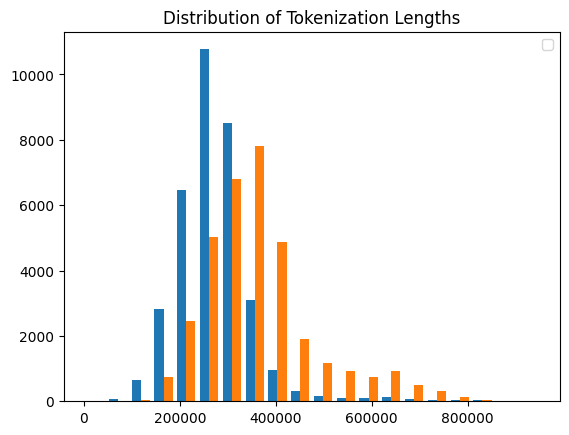

In [11]:
import random
lachnos_sample = random.sample(lachnos_lens, len(bacters_lens))
plt.hist([lachnos_sample, bacters_lens], bins=20)
plt.title("Distribution of Tokenization Lengths")
plt.legend("Lachnospiraceae", "Bacteroidaceae")

In [14]:
a = np.random.randn(10, 6)
b = np.random.randn(6, 10)
c = np.dot(a, b)
c.shape

(10, 10)